# Problem Statement: Hierarchical Multi-Agent Systems with Langgraph

*This assignment focuses on building a **Hierarchical Multi-Agent system** using **LangGraph** to orchestrate complex tasks, leveraging the core capabilities of an LLM.*

---

## Objective

Create a multi-agent system using a **supervisor agent** to manage a team of specialized agents. This system will handle complex requests by intelligently routing them to the correct agent for tasks such as:

-   **Research**: Using web search and RAG for information retrieval.
-   **Publishing**: Reviewing, writing, and creating data visualizations.

The goal is to produce a complete and accurate response by having the right agent perform the right task at the right time.

---

## Multi-Agent System (Essential Features)

### Inputs

- **User Query**: A natural language input that can be a question, a command, or a request.
  - *(e.g., “Fetch India's GDP over the past 5 years, then draw a line graph of it.”)*
  - *(e.g., "Find the latest news on AI, summarize it, and save the summary to a text file.")*
  - *(e.g., "Using our internal data, write a report on quarterly sales performance.")*

### Output

- **Final Result**: The comprehensive and processed output generated by the multi-agent system. This can be:
  - A definitive answer to a question.
  - A generated document (e.g., `final.txt` from the Writing Agent).
  - A data visualization (e.g., a line graph or chart from the Visualization Agent).
  - A structured report or summary based on the user's request.

---

## Backend Setup

We'll use [this](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor-tool-calling) reference for the supervisor multi-agent architecture (where sub-agents are exposed as tools!).

### Agent Roles

- **Supervisor Agent**: Manages the workflow and routes tasks to specialized teams and agents.
- **Search Team**: A team managed by the Supervisor Agent, responsible for gathering information.
  - **RAG Agent**: A specialized agent within the Search Team with access to a custom dataset for retrieval-augmented generation.
  - **Web Search Agent**: A specialized agent within the Search Team with access to web search tools to gather real-time information.
- **Publishing Team**: A team managed by the Supervisor Agent, responsible for reviewing, writing, and visualizing content.
  - **Reviewing Agent**: A specialized agent within the Publishing Team that reviews and refines content.
  - **Writing Agent**: A specialized agent within the Publishing Team responsible for generating the final written output.
  - **Visualization Agent**: A specialized agent within the Publishing Team responsible for creating data visualizations, charts, or graphs.

### Workflow

1. The user provides a query or task.
2. The Supervisor Agent analyzes the request and routes it to the appropriate team: either the **Search Team** or the **Publishing Team**.
3. **If the task is routed to the Search Team:**
   - The team's internal logic or a sub-supervisor decides whether to use the **RAG Agent** (for internal data) or the **Web Search Agent** (for external data).
   - The selected agent performs its task and returns the results.
4. **If the task is routed to the Publishing Team:**
   - The team's internal logic or a sub-supervisor determines the sequence of actions. For example, it might route the task to the **Reviewing Agent** first, then the **Writing Agent**, and finally the **Visualization Agent** if visualizations are required.
   - Each agent performs its specific task.
5. The final output, which may include a combination of reviewed text, written content, and visualizations, is presented to the user.

---

# Part 1: Implement the Solution

## Setup

In [34]:
# Import all necessary libraries
from langchain_tavily import TavilySearch
from langchain_experimental.tools import PythonREPLTool
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from IPython.display import Image, display
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from uuid import uuid4
from IPython.display import Image
import datasets
import os, getpass
from dotenv import load_dotenv

In [35]:
# Load environment variables and API Keys here

load_dotenv(override=True)
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Defining Components

### Chat Model

In [36]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    api_key=os.environ["OPENAI_API_KEY"],   
    model="gpt-4o-mini"                  
)


### Embedding Model

In [37]:
# Create embeddings

from langchain.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

### Vector Store

In [38]:
# Initialize ChromaDB with a persist directory set

from langchain.vectorstores import Chroma

vectorstore = Chroma(
    collection_name="miniLM_docs",        
    embedding_function=embedding_model,
    persist_directory="./chroma_db_miniLM" 
)

### Tools

In [39]:
# Initialize websearch tool with maximum 5 results

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(
    max_results=5
)

In [40]:
# Initialize Python REPL tool
# The PythonREPLTool has moved to langchain_experimental

from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()

## Create Specialized Agents

### Web Search Agent

In [41]:
# Define web search tool

def web_search(query: str) -> str:
    """Search the web for information."""
    
    # Get web search results 
    documents = web_search_tool.run(query)
    web_results = "\n".join([doc["title"] + " " + doc["content"] for doc in documents["results"]])
    
    return web_results

In [42]:
# Define web search agent using create_react_agent()

from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model=llm,                            
    tools=[web_search_tool, python_repl_tool],
    name="research_agent",                  
    prompt=(
        "You are an AI research assistant. "
        "You have two tools at your disposal:\n"
        "  1) web_search — to search the web (max 5 results)\n"
        "  2) python_repl — to execute Python code snippets safely\n\n"
        "Think through whether to call web_search or python_repl, "
        "use them as needed, then give the final answer."
    )
)

### RAG Agent

#### Set up Vector DB

##### Loading Documents

In [43]:
# Load dataset
knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [44]:
# DEBUG: HuggingFace connectivity

from huggingface_hub import login
login(token=os.environ["HUGGINGFACE_HUB_TOKEN"])

from huggingface_hub import whoami
print(whoami())

{'type': 'user', 'id': '681302216d5c6d53fc26d9f3', 'name': 'jayraj412', 'fullname': 'Jayraj Choudhury', 'email': 'choudhuryjayraj@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/no-auth/RWco44RWSepAmtTdvb2LL.png', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'test_token', 'role': 'write', 'createdAt': '2025-08-24T15:12:14.521Z'}}}


In [45]:
# Filter for transformer articles
knowledge_base = knowledge_base.filter(lambda row: row["source"].startswith("huggingface/transformers"))

In [46]:
# Create list of documents
source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

##### Splitting Documents

In [47]:
# Initialize splitter 

from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200
)

In [ ]:
# Perform splitting

from langchain.document_loaders import UnstructuredURLLoader

sample_urls = [
    "https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science"
]
loader = UnstructuredURLLoader(urls=sample_urls)
docs = loader.load()

# now split the loaded documents
# new_docs is a list of Document chunks can be indexed into ChromaDB or processed downstream
new_docs = text_splitter.split_documents(docs)


##### Storing Documents in Vector Store

In [49]:
# Store in Chroma – 100 rows only for quicker processing – and make sure to add UUIDs
import uuid

# Generate a unique UUID for each document (up to 100)
num_docs = min(100, len(new_docs))
uuids = [str(uuid.uuid4()) for _ in range(num_docs)]


# Add documents
vectorstore.add_documents(
    documents=new_docs[:num_docs],
    ids=uuids
)

# Persist Chroma DB so that it’s saved on disk
vectorstore.persist()

In [50]:
# DEBUG: Embedding Dimension

example_embedding = embedding_model.embed_query("test")
print(len(example_embedding))  

384


#### RAG Agent

In [51]:
# Define RAG Tool
def rag_search(query:str):
    "Function to do RAG search that returns 4 documents"
    # Define retriever
    retriever = vectorstore.as_retriever(search_kwargs={"k": 4})
    
    # Retrieve documents
    docs = retriever.get_relevant_documents(query)
    return "\nRetrieved documents:\n" + "".join(
        [
            f"\n\n===== Document {str(i)} =====\n" + doc.page_content
            for i, doc in enumerate(docs)
        ]
    )

In [52]:
# Define RAG agent using create_react_agent()

from langgraph.prebuilt import create_react_agent

rag_agent = create_react_agent(
    llm,
    tools=[rag_search, python_repl_tool],
    name="rag_agent",
    prompt=(
        "You are a Retrieval-Augmented Generation (RAG) agent. "
        "You have one tool available:\n"
        "  • rag_search(query: str) → str: retrieves the top 4 relevant document chunks.\n\n"
        "When given a user query, think step-by-step: decide whether to call rag_search, "
        "invoke it with the appropriate query, then use the returned documents to craft a complete answer."
    )
)


### Reviewing Agent

In [53]:
# Define reviewer tool
def review_content(input:str):
    "Reviews the content"
    prompt = f"review the given content {input} , make necessary corrections and rewrite in a positive tone "
    return model.invoke(prompt)

In [54]:
# Define reviewer agent using create_react_agent()

from langgraph.prebuilt import create_react_agent

reviewing_agent = create_react_agent(
    llm,                          
    tools=[python_repl_tool],            
    name="reviewing_agent",
    prompt=(
        "You are a Python code review assistant. "
        "You have one tool:\n"
        "  • python_repl(code: str) → str: execute Python code and return the output.\n\n"
        "When given a code snippet, think through whether to run it in python_repl, "
        "invoke the tool to validate behavior, and then provide concise feedback on errors or improvements."
    )
)

### Writing Agent

In [55]:
# Define writer tool
def writer(text_to_dump:str):
    "Writes in txt file"
    with open("final.txt", "w") as f:
        f.write(text_to_dump)
    print("Text has been written to final.txt")

In [56]:
# Define writer agent using create_react_agent()

from langgraph.prebuilt import create_react_agent

writing_agent = create_react_agent(
    llm,                        
    tools=[rag_search],                
    name="writing_agent",
    prompt=(
        "You are a creative writing assistant. "
        "You have one tool available:\n"
        "  • rag_search(query: str) → str: retrieves the top 4 relevant document chunks.\n\n"
        "When given a topic or user prompt, think step-by-step: decide if you need to call rag_search, "
        "invoke it to gather background, then compose a clear, well-structured written response tailored to the user's needs."
    )
)

### Visualization Agent

In [57]:
# Define visualization agent using create_react_agent()

from langgraph.prebuilt import create_react_agent

visualization_agent = create_react_agent(
    llm,                         
    tools=[python_repl_tool],           
    name="visualization_agent",
    prompt=(
        "You are a data visualization assistant. "
        "You have one tool available:\n"
        "  • python_repl(code: str) → str: execute Python code and return the output.\n\n"
        "When given a request to visualize data, think through whether to call python_repl to generate charts, "
        "invoke it with the appropriate code (e.g., matplotlib), then present the final visualization or code snippet."
    )
)

## Create Supervisor Workflow

### Search Team

In [58]:
# Create supervisor agent for web search 
search_team = create_supervisor(
    agents = [research_agent, rag_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a web search expert and a RAG search expert. "
        "For current events and information, use research_agent."
        "For transformer related information , use rag_agent."
    )
).compile(name="search_team")

### Publishing Team

In [59]:
# Create supervisor agent for publishing

publishing_team = create_supervisor(
    agents=[writing_agent,visualization_agent],
    model=llm,
    prompt=(
        "You are a publishing supervisor coordinating two specialists:\n"
        "- writing_agent crafts clear, engaging content using RAG for sourcing.\n"
        "- visualization_agent generates charts and visual aids via Python REPL.\n\n"
        "For narrative and copy tasks, delegate to writing_agent; for any visual or chart needs, delegate to visualization_agent. "
        "Then combine their outputs into a cohesive deliverable."
    )
).compile(name="publishing_team")
 

### Overall Supervisor

In [60]:
# Create overall supervisor agent and add extra argument: output_mode="full_history"

top_level_supervisor = create_supervisor(
    agents=[search_team, publishing_team],
    model=llm,
    prompt=(
        "You are the top-level supervisor coordinating two teams:\n"
        "- search_team: web research and retrieval experts\n"
        "- publishing_team: content writing and visualization experts\n\n"
        "Analyze the user’s request, delegate subtasks to the appropriate team, "
        "and then merge their outputs into a single response."
    ),
    output_mode="full_history"
).compile(name="top_level_supervisor")

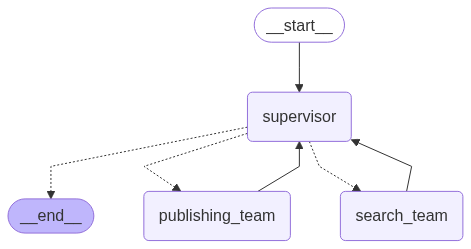

In [61]:
display(Image(top_level_supervisor.get_graph().draw_mermaid_png()))

## Test Runs

### Test Run 1

In [79]:
result = top_level_supervisor.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Explain how can EV adoption help protect earth and save the explanation into a text file."
        }
    ]
})

In [80]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Explain how can EV adoption help protect earth and save the explanation into a text file.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_search_team (call_svFrBJoDPthr2ani7zltD6YA)
 Call ID: call_svFrBJoDPthr2ani7zltD6YA
  Args:
================================= Tool Message =================================
Name: transfer_to_search_team

Successfully transferred to search_team
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_arqYXcZDYgPVZpZToPtv1phU)
 Call ID: call_arqYXcZDYgPVZpZToPtv1phU
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Na

### Test Run 2

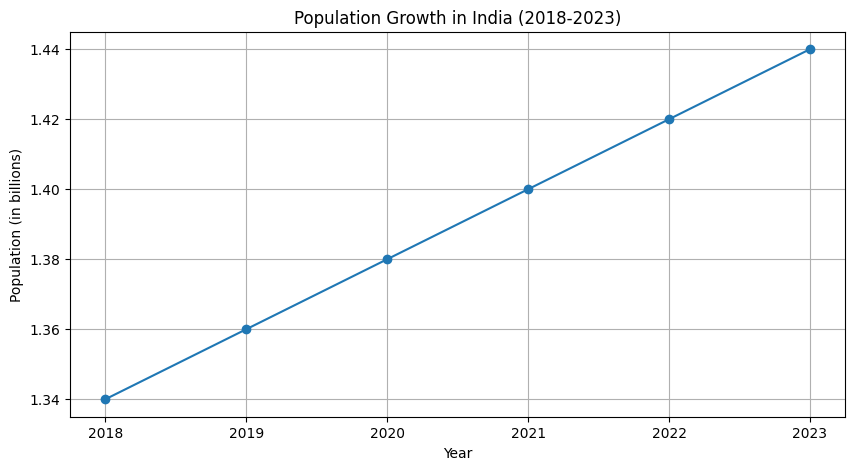

In [77]:
result = top_level_supervisor.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Fetch the growth of India's population over last 5 years time period and plot a graph for it."
        }
    ]
})

In [78]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Fetch the growth of India's population over last 5 years time period and plot a graph for it.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_search_team (call_RBUXKB87aNcVkfCkr1j6gmH5)
 Call ID: call_RBUXKB87aNcVkfCkr1j6gmH5
  Args:
================================= Tool Message =================================
Name: transfer_to_search_team

Successfully transferred to search_team
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (call_fYjJdbinjv0sAcwGW7enVrrS)
 Call ID: call_fYjJdbinjv0sAcwGW7enVrrS
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message =================================